# Fonis Datageeks
## Workshop: Intro to Machine Learning: Classification and Regression
### 1. Klasifikacija
Pripremio: [Dimitrije Milenković](https://www.linkedin.com/in/dimitrijemilenkovicdm/)
<br>dimitrijemilenkovic.dm@gmail.com
***

Stigli smo do treće celine i dugo očekivanog mašinskog učenja! :-)

Ovim notebookom krećemo da se bavimo prediktivnom analizom. Glavna razlika između eksploratorne i prediktivne analize je ta što se eksploratorna analiza bavi objašnjavanjem pojava koje su se već desile (uočene iz podataka), dok prediktivna analiza pokušava da predvidi buduće pojave.

U ovom notebooku radimo sa [Social Network Ads](https://www.kaggle.com/rakeshrau/social-network-ads), setom podataka o kampanji na društvenim mrežama za određeni proizvod sa podatkom o tome da li je korisnik kupio prozivod nakon što je video reklamu. 
<br>Za početak, ajmo da učitamo dataset i malo ga istražimo:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams

In [2]:
df = pd.read_csv('data/Social_Network_Ads.csv')
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19.0,19000.0,0
1,15810944,Male,35.0,20000.0,0
2,15668575,Female,26.0,43000.0,0
3,15603246,Female,27.0,57000.0,0
4,15804002,Male,19.0,76000.0,0


Dakle, u ovom slučaju posmatramo korisnike kojima je predstavljena reklama za naš proizvod. Podsetimo se, redovi su obzervacije, to jest jedan red je jedan korisnik. Kolone su osobine, tj. atributi tih korisnika. Atributi u ovom setu su pol, godine, plata i da li je kupio proizvod ili ne.

## Brzinski uvid u podatke — EDA Obnavljanje 

EDA je uvek polazna tačka kada dobijemo novi dataset, što nama sada i odgovara jer ćemo se taman podsetiti šta smo naučili na prethodnoj radionici. Pre nego da uključim neki atribut u algoritam, želim da vidim kako se on ponaša, između kojih vrednosti se kreće i da budem siguran da znam šta znači taj atribut. Deskriptivna statistika je na describe() daleko od nas.  

In [3]:
df[['EstimatedSalary','Age']].describe()

,EstimatedSalary,Age
count,400.000000,400.000000
mean,69742.500000,37.655000
std,34096.960282,10.482877
min,15000.000000,18.000000
25%,43000.000000,29.750000
50%,70000.000000,37.000000
75%,88000.000000,46.000000
max,150000.000000,60.000000


Godine su potpuno jasne. Reklama je bila servirana korisnicima od 18 do 60 godina, sa prosekom od oko 37.655 što je očekivano. Count ukazuje na to da ukupno imamo 400 redova u datasetu.
Vidimo da je plata izražena u hiljadama. S obzirom da dataset nije iz Srbije, pretpostavljamo da je ovo ukupna godišnja plata izražena u evrima ili dolarima.

Ovo je deskriptivna statistika za numeričke atribute. Kako bi ona izgledala za neki kategorički atribut?

In [4]:
df[['Gender']].describe(include=['object'])

,Gender
count,400
unique,2
top,Female
freq,204


'Ajmo da proverimo da li se prosek godina i plate razlikuju kod onih koji su kupili proizvod i onih koji nisu, i to posebno za žene a posebno za muškarce. 

In [5]:
df.pivot_table(['EstimatedSalary', 'Age'],
              ['Purchased', 'Gender'], aggfunc='mean')

Age  EstimatedSalary
Purchased Gender                            
0         Female  33.110236     61480.314961
          Male    32.484615     59630.769231
1         Female  47.155844     88714.285714
          Male    45.500000     83424.242424

Dakle, funkcija pivot_table kao prvi parametar prima numeričke atribute na kojima će primenjivati agregatnu funkciju. Drugi parametar su kategorički atributi po kojima grupiše podatke, a treći aggfunc je funkcija koju će primenjivati na tako grupisane podatke.
<br>Iii...  već smo izvukli neko vredno **znanje iz podataka**. Vidimo da su kupovini našeg proizvoda skloni stariji korisnici sa platom iznad prosečne. Nema velike razlike između žena i muškaraca koji nisu kupili proizvod, dok to ne možemo da kažemo za one koji su kupili. Žene imaju veću platu.

Za početak ajmo da proverimo kakva je raspodela Godina naših korisnika. distplot je funkcija koja spaja grafik gustine i histogram.

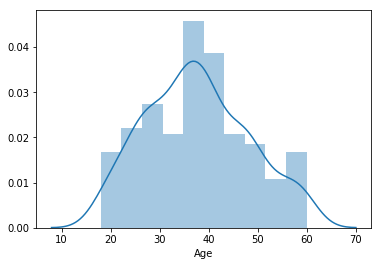

In [6]:
sns.distplot(df['Age'])

Godine se kreću od 18 do 60 i podležu normalnoj raspodeli. Najviše ih je između 35 i 40 (preko 50%). 

Sledeći zgodan grafik je **lmplot**, koji će na osnovu prosleđenih podataka odvojenih u kategorije po nekoj nijansi (hue parametar) pokušati da podesi regresioni model.

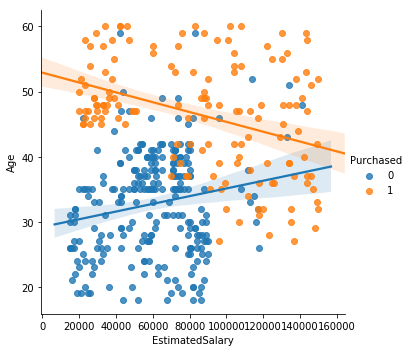

In [7]:
sns.lmplot('EstimatedSalary', 'Age', data=df, hue='Purchased')

Vidimo da naš proizvod kupuju stariji ljudi sa velikom platom, dok među mladima sa niskim primanjima nemamo ni jednog kupca. Interesantno je takođe što ljudi oko 45-50 godina sa malim primanjima veoma često kupuju naš proizvod. Dakle, vidimo da kod onih koji kupuju naš proizvod se godine smanjuju sa povećanjem plate. Očigledno da ne prodajemo neku osnovnu životnu namirnicu, već nešto luksuznije što je više potrebno starijima (pa ga kupuju i oni sa malom platom), ali ako si mlad i imaš para velika je verovatnoća da ćeš ga kupiti. Imaš ideju šta to može da bude? :-D 

## PDA — Prediktivna analiza podataka

### Čemu to?

Okej, pogledajmo još jednom naš dataset:

In [8]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19.0,19000.0,0
1,15810944,Male,35.0,20000.0,0
2,15668575,Female,26.0,43000.0,0
3,15603246,Female,27.0,57000.0,0
4,15804002,Male,19.0,76000.0,0


Dakle, imamo podatke o polu, godinama i plati naših korisnika. Na kraju, imamo podatak da li su se oni "upecali" na reklamu i kupili naš proizvod. Pogledajmo koliki procenat njih se upecao:

In [9]:
df['Purchased'].value_counts(normalize=True)

0    0.6425
1    0.3575
Name: Purchased, dtype: float64

Podsetimo se, value_counts je pandas funkcija koja prebrojava učestalost pojavljivanja neke vrednosti u koloni nad kojom se poziva. Ako je pozovemo bez parametara normalize, dobićemo broj pojavljivanja svake vrednosti, a ovako dobijamo procentualno.  
<br>Recimo da se reklama ovde plaćala po kliku. Platili smo 400 klika, a od toga je samo 35,75% njih stvarno kupilo moj proizvod na kraju. Sledeći put kada plaćam reklamu voleo bih da bude veći procenat njih. 

#### Možemo li to bolje?

Moguće da bi do većeg procenta uspešnih prodaja došli kada bi nekako mogli da za svakog korisnika, na osnovu njegovih osobina, *predvidimo* da li želi naš proizvod ili ne. Onda bi mogli da predstavimo naš proizvod samo korisnicima koji ga stvarno žele. 

Dakle, složićemo se da bi bilo strava kada bi mogli da na osnovu pola, godina i plate, i pre prikazivanja reklame, znamo **da li će korisnik kupiti proizvod ili ne**.

Dakle, treba nam neka funkcija: 
$$ f (godina, pol, plata) = kupioProizvod $$
Za početak imamo naše `x` (*atributi na osnovu kojih predviđamo*) i `y` (*atribut koji predviđamo*):

In [10]:
X = df.iloc[:, [2, 3]].values # za početak predviđamo samo na osnovu pola i plate
y = df.iloc[:, 4].values
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

Prisetimo se da metodom `iloc` nad pandas dataframe-om (df) možemo selektovati određene redove i kolone. Paketi za građenje modela obično rade sa numpy nizovima (jednodimenzionalnim ili multidimenzionalnim). Dodatkom `values` pandas seriju prevodimo u numpy niz. 

Naše x i y koristićemo kako bismo napravili **prediktivni model**. `X` zovemo osobinama ili odlikama (**features**), a `y` oznakom ili etiketom (**label**). Ukratko, features je input našeg modela, ono na osnovu čega predviđamo, a label je output, ono što predviđamo.

### Podela na trening i test

Međutim, ako učimo na svim podacima koje imamo, nećemo imati na čemu kasnije da proverimo da li naš model dobro predviđa. Iz tog razloga, podelićemo naš dataset na dva dela: na **trening** i **test** set. Na trening setu ćemo učiti, a na test setu ćemo kasnije proveriti koliko dobro smo naučili.

![training_test](img/training_test.png)

Za podelu dataseta iskoristićemo standardnu funkciju koja se nalazi u paketu scikit-learn. Upravo ovo nam je prvo korišćenje ovog divnog paketa. **Scikit-learn** sadrži većinu potvrđenog znanja o mašinskom učenju. Ono što je strava je što je to najbolje znanje na jedan poziv funkcije daleko od nas. Uskoro ćemo shvatiti koliko je sklearn genijalan paket. Conda dolazi sa preinstaliranim sklearnom, međutim u slučaju da ga nemate, možete ga instalirati sledećom komandom:
<br>[conda install -c anaconda scikit-learn](https://anaconda.org/anaconda/scikit-learn)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Klasifikacija

U mašinskom učenju, problemi kod kojih je potrebno predvideti neku postojeću ciljnu osobinu, tj label, nazivaju se problemima nadgledanog učenja (eng. [supervised learning](https://machinelearningmastery.com/supervised-and-unsupervised-machine-learning-algorithms/)). U zavisnosti od toga kog je tipa label koji želimo da predvidimo, problemi se razlikuju. U slučaju da želimo da predvidimo kategoriju tj. klasu (label može uzeti ograničen broj vrednosti), onda je to problem **klasifikacije**. 

Primenjeno na naš dataset, radi se o problemu klasifikacije jer želimo na osnovu osobina pol, godine i plata klasifikovati korisnike u 2 grupe (klase, kategorije): one koji će kupiti naš proizvod i oni koji neće. 

Još jednom, kada atribut koji predviđamo (label, rekosmo) ima ograničen skup vrednosti, to jest kategorički je, radi se o problemu klasifikacije.

Klasifikacionim problemima se bave mnogi algoritmi kao što su Decision trees, Naive Bayes, knn, Random Forest, Support Vectore Machine i drugi. U nastavku biće objašnjeni neki od osnovnih. Za početak, krenimo od veoma popularnih [Decision treesa](https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052).

### Stabla odlučivanja

Stabla odlučivanja su široko rasprostranjena. Zasnivaju se na if-then pravilima. Često se koriste za generalizaciju ekspertskog iskustva radi daljeg širenja jer su veoma lako interpretabilni. Zato su omiljeni među menadžerima i standardni kada je u pitanju npr. donošenje odluka da li će neko dobiti kredit ili ne. Evo jednog primera:

![kredit](img/tree.png)

 Pre nego da data science uzme maha, ovakva stabla koja se bave odlukama o kreditima formirana su kao generalizacija znanja eksperata. Danas su ona naučena iz podataka. Kako? 

### Kako gradimo stablo odlučivanja iz podataka?
Ovaj algoritam radi tako što posmatra sve osobine (features) i pokušava da nađe onu po kojoj će podeliti podatke tako da dve grupe koje dobije budu što sličnije po oznaci koju treba da predvidi (label). Taj proces zatim ponavlja rekurzivno na obe grupe.
<br>Detaljnije o algoritmima za stabla možete pročitati [na linku](https://medium.com/deep-math-machine-learning-ai/chapter-4-decision-trees-algorithms-b93975f7a1f1). 

In [12]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

U tri linije napravili smo naš prvi prediktivni model. Preporuka je da uvek kada vidite da koristim neki novi koncept iz paketa, [pogledate dokumentaciju za njega](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Sklearnova dokumentacija kida, pa je glupo da je ne koristimo. ;-)

U drugom redu podešavamo naš algoritam za klasikaciju. Izabrali smo DecisionTreeClassifier po kriterijum entropija maksimalne dubine 3, što znači da će imati tri nivoa grananja i onda će stati bez obzira što (možda) nije uspeo da potpuno tačno klasifikuje podatke. Maksimalnom dubinom utičemo na složenost našeg modela. Na kraju koristimo random_state koji služi kao seed za random generesinja brojeva. Ovaj parametar ćemo uvek koristiti kako bismo osigurali da svi dobijamo iste rezultate.

Funkcijom fit prosleđujemo našem klasifikatoru podatke na osnovu kojih treba da izgradi model. Prvi parametar su features, drugi label. Ako ti i dalje nije jasno šta su features i labels, pogledaj [ovo strava objašnjenje](https://www.youtube.com/watch?v=rnv0-lG9yKU). 

Nego, **čestitam!** Zajedno smo izgradili naš **prvi prediktivni model**.

Pomenuo sam da je jedan od glavnih razloga popularnosti ove grupe algoritama njihova laka interpretabilnost. Bilo koja osoba koja ne mora da bude data scientist može lako da razume zbog čega je algoritam doneo konkretnu odluku. 
<br>Menadžeri nekada ne žele da poveruju u tvoj fensi SVM algoritam jer ga ne razumeju. Ne žele da poslušaju odluku mašine ako ne znaju kako je mašina to zaključila. U takvim situacijama spašavaju stabla. ;-)
<br>U nastavku pogledaj kakav prediktivni model smo izgradili:

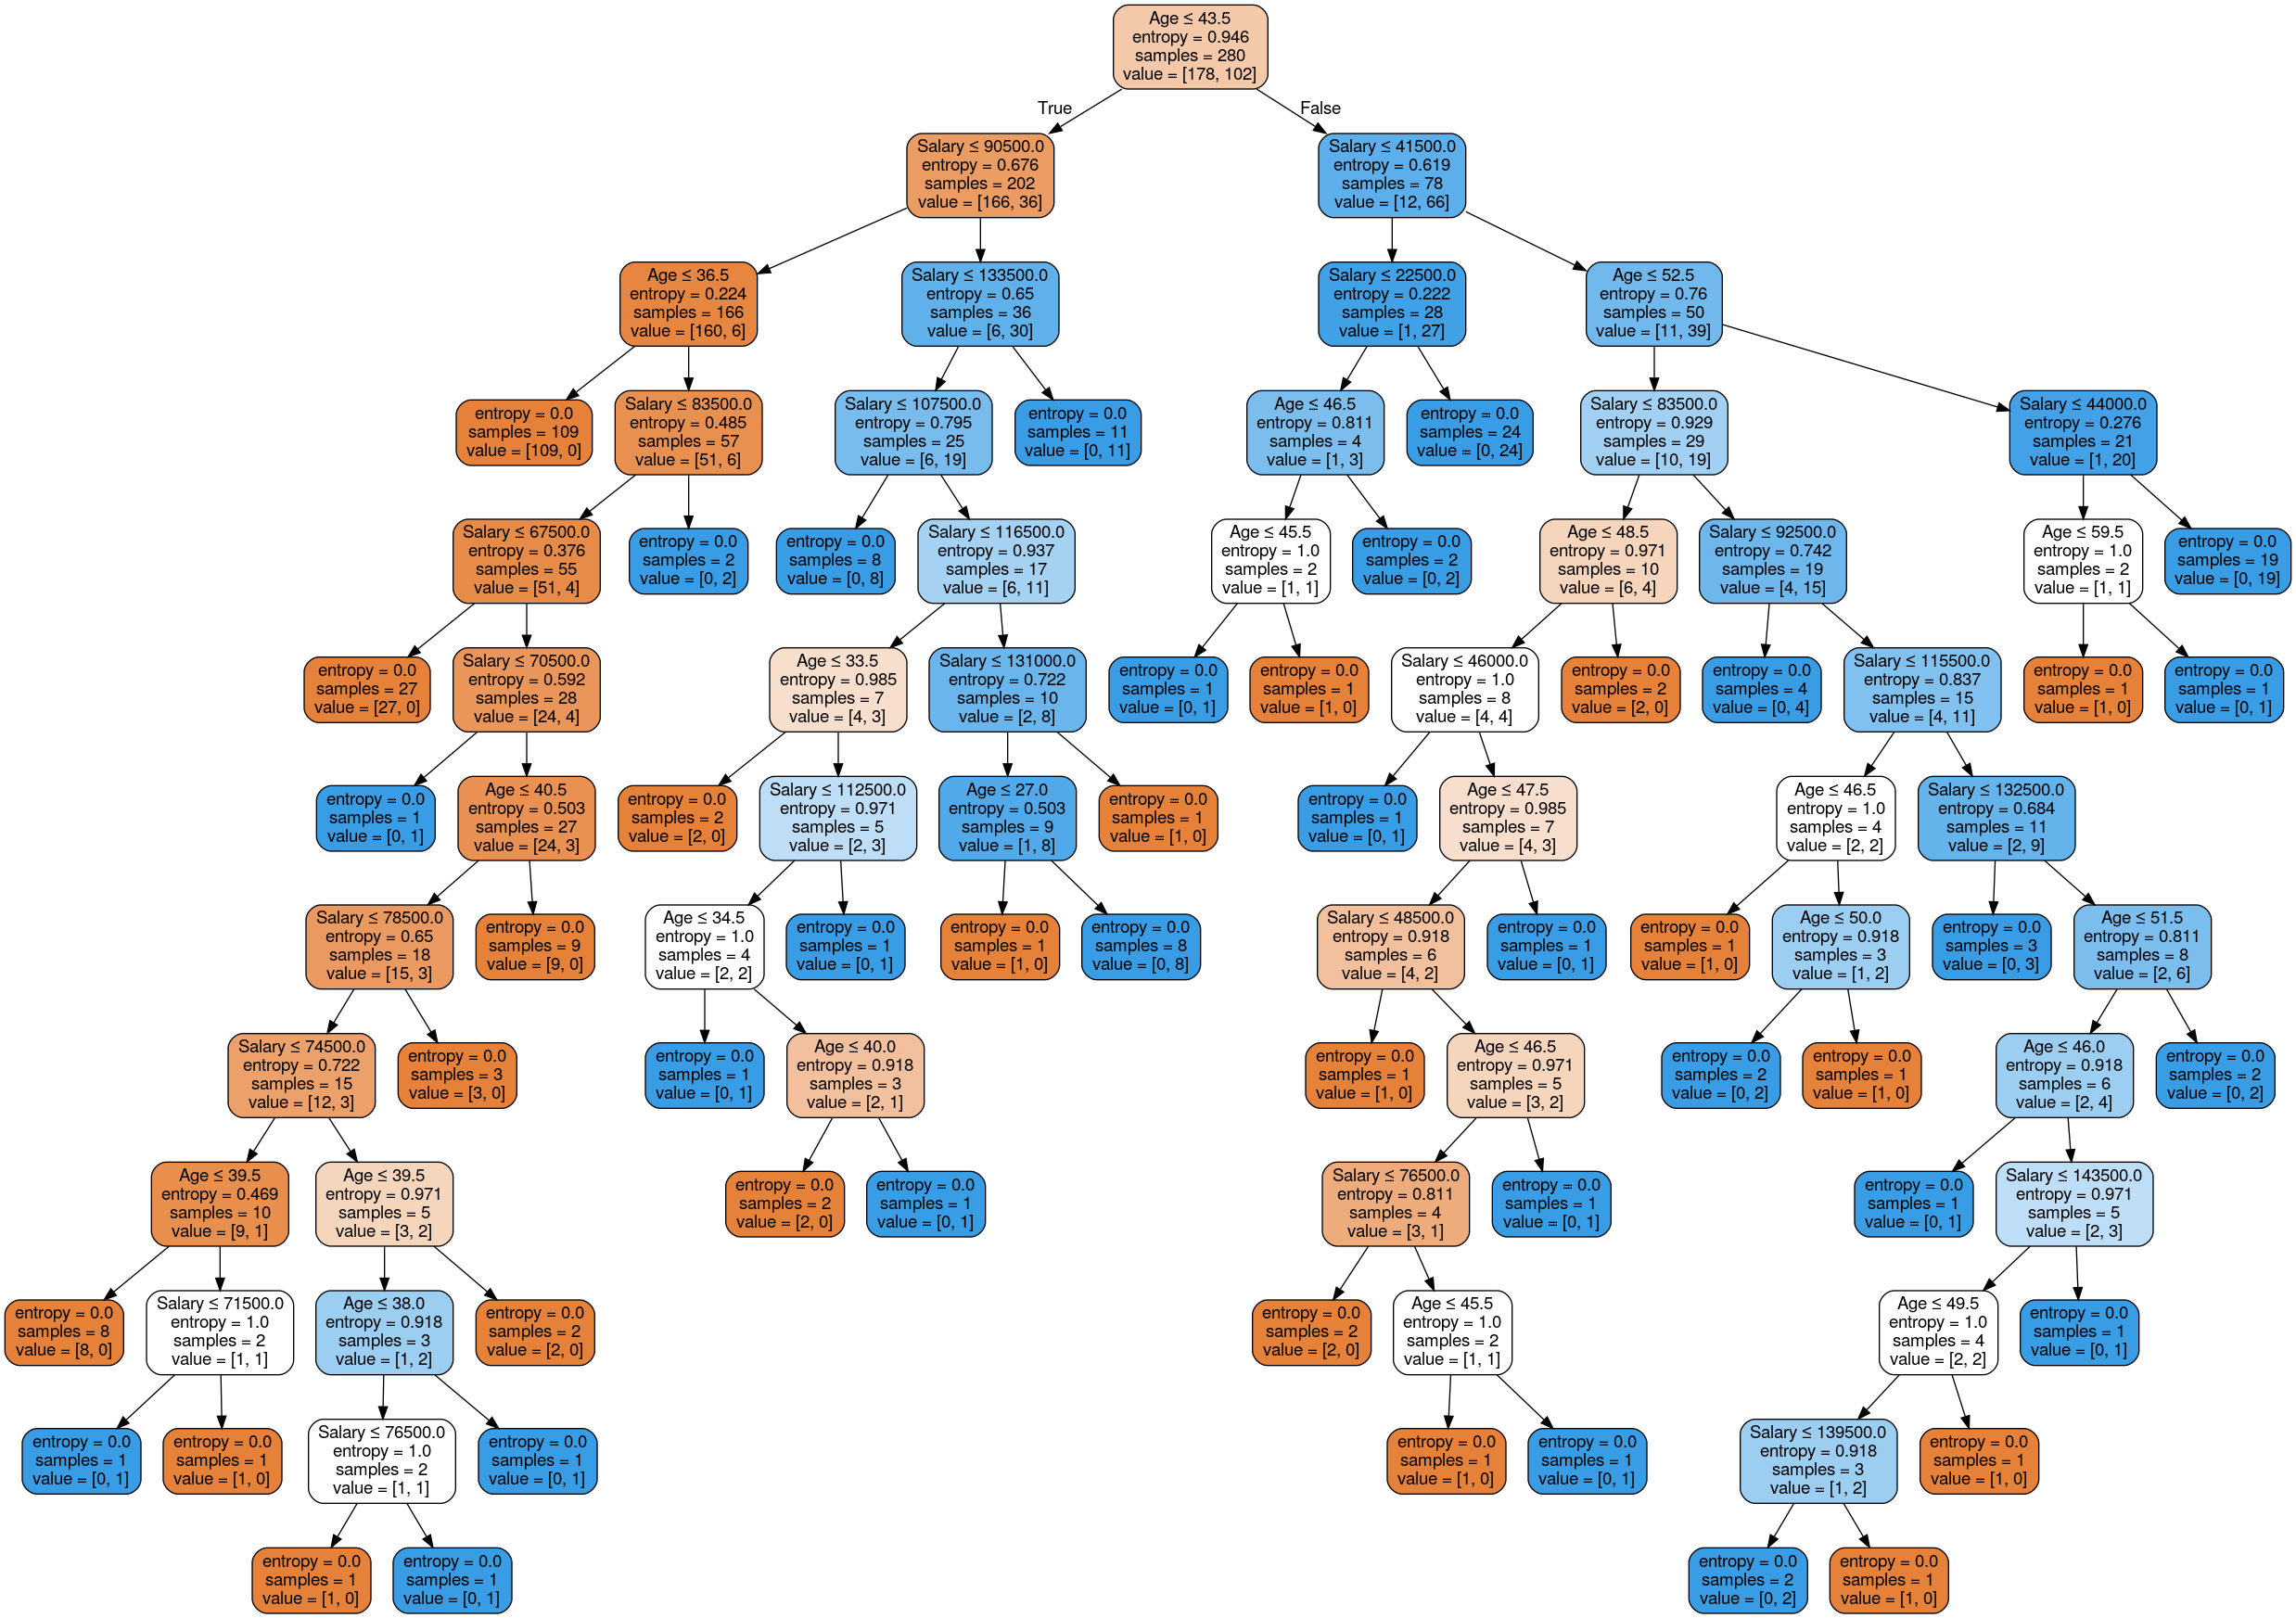

In [13]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=['Age', 'Salary'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

To je ta interpretabilnost o kojoj pričamo. Sada pogledajmo korisnika sa sledećim podacima:

In [14]:
df.iloc[1, :]

User ID            15810944
Gender                 Male
Age                      35
EstimatedSalary       20000
Purchased                 0
Name: 1, dtype: object

'Ajmo da proverimo da li će on kupiti naš proizvod.
1. Ima manje od 44.5 godina
2. Ima manju platu od 90500
3. Ima manje od 36.5 godina
4. Ima manju platu od 67500
<br>=> ovaj korisnik neće kupiti naš proizvod
<br>Probajte sami za ovu devojku:

In [15]:
df.iloc[7, :]

User ID            15694829
Gender               Female
Age                      32
EstimatedSalary      150000
Purchased                 1
Name: 7, dtype: object

Nakon što izgradimo model, potrebno je testirati ga na nekim podacima sa kojima se do sada nije susreo. Sećate se da smo podelili naš dataset na trening i test. Na treningu smo naučili model, a sada je vreme da ga primenimo na test podacima.

![training_test](img/training_test.jpg)

Kao što je `fit` standardna sklearn funkcija za izgradnju modela iz podataka, za predviđanje na osnovu novih podataka koristimo funkciju `predict`. Kao parametar joj šaljemo naš test dataset featuresa.

In [16]:
y_pred = classifier.predict(X_test)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

Pri rešavanju problema nadgledanog učenja u Pythonu uz korišćenje sklearna, možemo izdvojiti sledeće korake:
1. Učitati podatke (`pd.read_csv`)
2. Odrediti features osobine i target (label) osobinu (`X`, `y`)
2. Podeliti dataset na trening i test (`train_test_split`)
3. Učitati izabrani algoritam za izgradnju modela iz sklearna (`import`)
4. Inicijalizovati model i postaviti parametre modela 
5. Naučiti, to jest prilagoditi, model trening podacima (`fit`)
6. Korišćenjem napravljenog modela, predvideti rezultate za test podatke (`predict`)

i još dva koraka koja nas očekuju:
7. Vizualizovati rezultate modela na trening i test skupu
8. Evaluirati model poređenjem predviđenih rešenja sa test rešenjima

Ove korake dalje možete koristiti kao **template** za rešavanje problema nadgledanog učenja. Toplo preporučujemo da sada skrolujete gore notebook i uočite svaki od ovih koraka u kodu. 

### Algoritmi za izgradnju stabla odlučivanja

Pre nego da nastavimo sa koracima, 'ajmo da vidimo kako je tačno izgrađeno ovo stablo odlučivanja. Probajmo da razumemo algoritam.

Stabla se najčešće grade na osnovu dva algoritma:
1. ID3
2. CART

Kako bismo objasnili kako funkcioniše ID3, pogledajmo "hello world" dataset za stabla odlučivanja:

![id3](img/id3.jpeg)

Imamo 4 atributa koja opisuju vremenske prilike i na kraju atribut `play`, koji zapravo predstavlja odluku da li treba igrati golf ili ne. Dakle, potrebno je ova 4 atributa nekako mapirati u atribut koji želimo predvideti, `play`. Svi algoritmi mašinskog učenja (nadgledanog) zapravo pokušavaju da urade to mapiranje.

Ovako to radi ID3:
1. Na početku, potreban nam je *root node* stabla. Na osnovu kog atributa prvo granati?
> Izaberi onaj atribut koji najbolje klasifikuje trening podatke po play atributu

2. Kako mogu da utvrdim koji je to atribut?
> ID3 kaže: Uzmi atribut koji daje najveću Informacioni dobit

Kako bismo definisali Information Gain, potrebno je prvo definisati entropiju. Ovo je mera pozajmljena iz Informacione teorije i ona nam ukazuje na neuređenost podataka. Računa se na sledeći način:

![entropy](img/entropy.jpeg)

![ig](img/ig.jpeg)

Osnovni algoritam može se opisati sledećim koracima:
1. Izračunaj entropiju nad celim datasetom
2. Za svaki atribut:
       1. podeli dataset na podsetove sa različitim vrednostima određenog atributa
       2. izračunaj entropiju za svaki podset nastao deljenjem po određenom atributu
       3. izračunaj informacioni dobit pri deljenju po određenom atributu 
3. Granaj po atributu koji ima najveću informacionu dobit
4. Ponavljaj dok ne dobiješ zadovoljavajuće drvo 

Evo kako to izgleda na ovom primeru:

<center> <img src="img/id3primer.jpeg" height="400" width="400"> </center>
<center> <img src="img/id3primer2.jpeg" height="400" width="600"> </center>


<center> <img src="img/id3primer3.jpeg" height="300" width="400"> </center>

U binarnoj klasifikaciji (kakva je svaka pomenuta do sada), IG će imati vrednost.
- 0, ako su svi podaci klasifikovani po atributu `play` yes ili su svi no
- 1, ako ima 50% yes podataka a 50% no podataka

#### CART

CART algoritam kao meru za grananje koristi Gini index.

<center> <img src="img/gini.png" height="200" width="200"> </center>

Gini indeks nam pokazuje koliko dobro su podeljeni podaci tako što meri koliko su pomešani. Za savršena podelu gini indeks je 0, dok je najgori slucaj da ih ima 50-50 i tada bi max Gini indeks bio: 
$$ = 1 — (1/2)^2 — (1/2)^2
= 1–2*(1/2)^2
= 1- 2*(1/4)
= 1–0.5
= 0.5 $$

Kao i kod ID3-a, računa se Gini index nad svim podacima, bira se grananje po onom atributu za koji je najmanji Gini i proces se ponavlja rekurzivno. Dakle, koraci su slični:

1. compute the gini index for dataset
2. for every attribute/feature:
       1. calculate gini index for all categorical values
       2. take average information entropy for the current attribute 
       3. calculate the gini gain
3. pick the best gini gain attribute.
4. Repeat until we get the tree we desired.

Sklearn ima ugrađene i ID3 i CART algoritme. Malopre smo koristili ID3 jer smo klasifikatoru prosledili method='entropy', a u slučaju da želimo da koristimo gini, intuitivno, potrebno je proslediti:

In [17]:
cart_classifier = DecisionTreeClassifier(criterion = 'gini', max_depth=3, random_state = 0)
cart_classifier.fit(X_train, y_train)
cart_ypred = cart_classifier.predict(X_test)
cart_ypred[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

> U slučaju da ti iz ovoga nije jasno kako funkcioniše algoritam, pogledaj snimak radionice ili pročitaj blog iz grupe. Znam da ovo može još bolje i detaljnije, ali je za to potrebno malo više vremena.

`Poruka za najjače datageekove:`
>>Zato imaš priliku da mi pomogneš da ovi materijali budu bolji. Ako želiš da potvrdiš svoje razumevanje algoritma za Stabla (ili kasnije kNN), javi mi se i možeš kreirati notebook u kome ti objašnjavaš algoritam na svoj način. 
Tako ćeš potvrditi svoje znanje, a ja i svi oni koji prelaze ove materijale kasnije će ti biti jako zahvalni. 'Ajmo da napravimo zajedno najjače materijale ikada! :)

### Evaluacija modela

Super, imamo prva predviđanja našeg modela smeštena u varijablu y_pred. 

In [18]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1])

Sada bi bilo zgodno da proverimo koliko je dobro naš model predvideo. To možemo uraditi tako što ćemo uporediti predviđene podatke sa stvarnim (`y_test`).

Popularan način za to je **matrica konfuzije**. I za to postoji funkcija u sklearn, potrebno je samo da joj prosledim podatke o stvarnom labelu i podatke o labelu koji je predvideo naš algoritam.

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[70,  9],
       [ 4, 37]])

In [20]:
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp

(70, 9, 4, 37)

Confussion matrix sadrži redom brojeve korisnika za koji je algoritam:
- True Negative (tn) - predvideo da **neće kupiti** proizvod i oni stvarno **nisu kupili**
- False Positive (fp) - predvideo da **će kupiti** proizvod, a oni zapravo **nisu kupili**
- False Negative (fn) - predvideo da **neće kupiti** proizvod, a oni su **kupili**
- True Positive (tp) - predvideo da **će kupiti** proizvod i oni su stvarno **kupili**

Jedna od popularnih mera tačnosti ovakvih modela jeste accuracy. On se računa na sledeći način:

In [21]:
accuracy = (tn+tp) / (tn+fp+fn+tp) # tačno predviđeni / svi predviđeni 
accuracy

0.8916666666666667

Napomena: FP je greška druge vrste, FN je greška prve vrste.

<center> <img src="img/cm.jpeg" height="300" width="300"> </center>
<center> <img src="img/preccision_recall.png" height="300" width="300"> </center>


Pored accuracy-ja koji meri ukupnu tačnost modela, postoje dve specifičnije mere. 

Prva je precision, koja meri **koliko negativnih se modelu ušunja među pozitivnim**, odnosno *sposobnost modela da identifikuje samo pozitivne slučajeve*. U našem slučaju, koliko često model kaže da će kupac kupiti proizvod a on zapravo ne kupi.

In [22]:
precision = tp / (tp+fp) # tačni pozitivni / svi predviđeni pozitivni
precision

0.8043478260869565

<center> <img src="img/precission.png" height="400" width="400"> 
<img src="img/recall.jpeg" height="400" width="400">
</center>


Druga mera je recall, koja meri **koliko pozitivnih slučajeva modelu promakne**, to jest *sposobnost modela da primeti sve pozitivne slučajeve*. U našem slučaju, za koliko kupaca model kaže da neće kupiti proizvod iako će oni kupiti.

In [23]:
recall = tp / (tp+fn) # tačni pozitivni / svi stvarni pozitivni
recall

0.9024390243902439

Ako posmatramo naš slučaj, primetićemo da nam je recall mnogo bitnija mera. Ako pustimo reklamu nekome ko zapravo neće kupiti proizvod, ništa strašno se neće desiti (do sada je bilo 80% takvih). Međutim, ako propustimo sigurnim kupcima da ponudimo proizvod, to je mnogo veći gubitak.
Tako je pri mnogim primenama klasifikacije:
- medicina: predvideti da li pacijent ima određenu bolest ili ne
- prodaja: da li kupiti proizvod ili ne
- odnos sa klijentima: da li će klijent promeniti operatora ili ne
- `spam` (JEDINI DRUGACIJI)




In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
recall_score(y_test, y_pred)

0.9024390243902439

### Vizualizacija rezultata modela

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


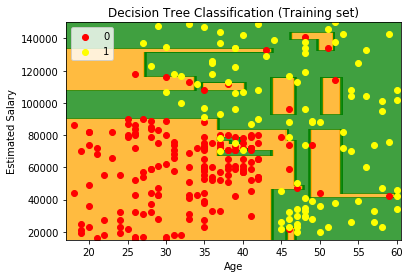

In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.5),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.5))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('orange', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'yellow'))(i), label = j)
plt.title('Decision Tree Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

`Skriveni domaći zadatak:` Prava prilika da jednim zadatkom obnoviš znanje sa prve i druge radionice, pritom malo pročitaš dokumentaciju i skapiraš vizualizaciju modela. Do petka napravi notebook sa ovim kodom, opisom svake funkcije koja se poziva i objašnjenjem kako je i šta je kreirano. Pošalji mi to i brzo odgovaram. :D

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


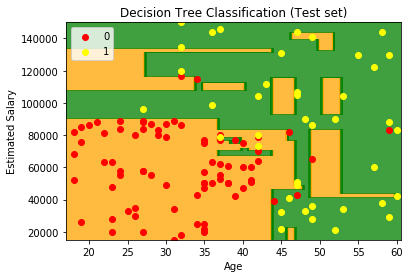

In [26]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.5),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.5))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('orange', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'yellow'))(i), label = j)
plt.title('Decision Tree Classification (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

### Overfitting and underfitting

- Gledaj sa slika: Narandzasta i zelena povrsina su rasponi plata i godina za koje algoritam predvi]a da neće, odnosno hoće kupiti proizvod. Crvene i žute tačke su stvarni podaci -- boje ukazuju na to da li nisu kupili ili su kupili proizvod.
- Kada je crvena tačka na narandžastoj površini to znači da model tačno predviđa da neće kupiti proizvod. Kada je žuta na zelenoj površini, takođe model tačno predviđa. Za suprotno greši.
- Posmatramo prvi grafik: Na njemu tačkice predstavljaju trening podatke. Vidimo da je tu naš model veoma tačan -- skoro sve tačkice su na svojoj površini. To je i logično jer smo nad tim podacima (tim tačkama) i trenirali naš model. Normalno je da za podatke nad kojim je naučen model predviđa dobro -- za njih zna rešenje.
- Posmatramo drugi grafik: Ovde su tačkice iz trening seta. Vidimo da ima dosta praznih pravouganika (to jest naučenih pravila koja nisu primenjena). Okej, to je možda zato što *nemamo dovoljno podataka u test datasetu*. Međutim, u gornjem desnom uglu vidimo da je model naučio pravilo da ti korisnici neće kupiti proizvod, a zapravo to uopšte nije pravilo -- u toj figuri su čak dva korisnika koja su kupila proizvod (2 žute tačke). 
- Dakle, izgleda da smo napravili previše složen model, koji je pokušao da uhvati svaki od izuzetaka u istorijskim podacima (trening podacima) i da se prilagodi njima. Zato je veoma tačan na trening setu.
- Međutim, na test setu katastrofalno greši jer ima pravila za "hvatanje" izuzetaka, a to nisu pravila pa se neće ponoviti u test datasetu niti u budućnosti.
- To znači da nam se desio **overfitting**, to jest pretrenirali smo naš model. Dakle, Overfitting se dešava kada model previše prilagodimo trening podacima, napravimo ga složenim tako da zna pravila koja zapravo nisu pravila već izuzeci, pa je zbog toga veoma tačan na treningu, dok kasnije stalno greši (na testu i u budućnosti). 
- Jedan od načina borbe protiv overfittinga je **ograničavanje složenosti modela**. Složenost modela se ograničava podešavanjem njegovih parametara.
- Kod stabla to je tzv. obrezivanje stabla to jest **pruning**. On se postiže podešavanje maksimalne dubine stabla (max_depth) ili maksimalnim brojem slučaja u listu (max_samples_leaf) i sličnim parametrima o kojima možete pročitati u [dokumentaciji](https://scikit-learn.org/stable/modules/tree.html).

In [27]:
pruned_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, max_depth=3)
pruned_classifier.fit(X_train, y_train)
yp_pruned = pruned_classifier.predict(X_test)
accuracy_score(y_test, y_pred), accuracy_score(y_test, yp_pruned)

(0.8916666666666667, 0.9166666666666666)

Dakle, vidimo da smo ovakvim ograničavanje složenosti modela povećali tačnost našeg modela. Sada kada pogledamo vizualizacije, videćemo da naš model nije više toliko tačan na trening podacima, ali je zato tačniji na test podacima, što nam je i cilj:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


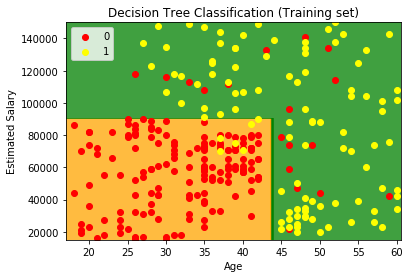

In [28]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.5),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.5))
plt.contourf(X1, X2, pruned_classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('orange', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'yellow'))(i), label = j)
plt.title('Decision Tree Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


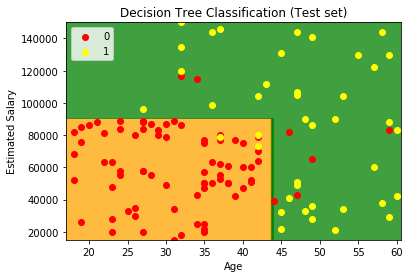

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.5),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.5))
plt.contourf(X1, X2, pruned_classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('orange', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'yellow'))(i), label = j)
plt.title('Decision Tree Classification (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

Međutim, pri smanjivanju složenosti, možemo preterati:

In [3]:
simple_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, max_depth=2)
simple_classifier.fit(X_train, y_train)
yp_simple = simple_classifier.predict(X_test)
accuracy_score(y_test, y_pred), accuracy_score(y_test, yp_simple)

NameError: name 'DecisionTreeClassifier' is not defined

Vidimo da smo u ovom slučaju ograničili drvo na samo jedno grananje. Time smo napravili previše jednostavan model koji loše predviđa i na treningu i na testu:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


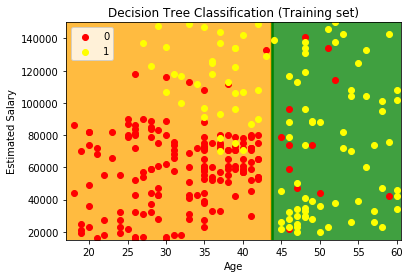

In [31]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.5),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.5))
plt.contourf(X1, X2, simple_classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('orange', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'yellow'))(i), label = j)
plt.title('Decision Tree Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


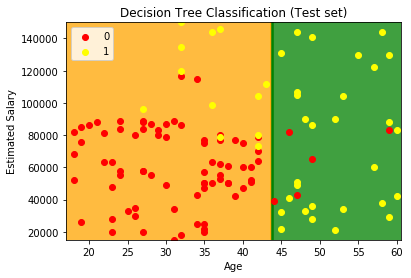

In [32]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.5),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.5))
plt.contourf(X1, X2, simple_classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('orange', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'yellow'))(i), label = j)
plt.title('Decision Tree Classification (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

Vidimo da smo ovako prostim modelom za veliki broj korisnika koji će kupiti proizvod (žuti) predvideli da neće (narandžasta površina). 

Za razliku od overfittinga, sa druge strane, ako napravimo previše jednostavan model, on neće koncipirati izuzetke kao pravila, ali zato neće ni skontati pravila. Ova pojava naziva se **underfitting**.

Kada pričamo o overfittingu i underfittingu, mi se zapravo bavimo trade-offom između pristrasnosti i varijacije, odnosno:

#### Bias. vs Variance Trade-off

- Modeli sa **velikim biasom** ne obraćaju mnogo pažnje na trening podatke i zapravo su previše jednostavni. Zato previše greše i nad trening podacima i nad test podacima.
- Modeli sa **velikom varijacijom** obraćaju mnogo pažnje na trening podatke i jako su složeni. Veoma su tačni na trening podacima, ali zato nad test podacima mnogo greše. 

Pri izradi prediktivnog modela, trudimo se da napravimo što bolji bias vs. variance trade-off.

<center> <img src="img/biasvariance.png" height="400" width="400"> 
</center>

Pogledati [ovaj interesantan infografik](https://elitedatascience.com/bias-variance-tradeoff) za bolje razumevanje.

## kNN (k-Nearest Neighbors) kao klasifikator

kNN algoritam zasniva se na sličnosti osobina (features), odnosno on podrazumeva princip da će *novi slučaj (slučaj za koji se predviđa) biti one klase koje su slučajevi najsličniji njemu po ostalim osobinama*.

<center> <img src="img/knn.png" height="400" width="300"> 
</center>

Algoritam funkcioniše na sledeći način:

1. Odrediti pozitivan broj k
2. Za novi slučaj (novi red podataka) izračunaj udaljenost od ostalih slučajeva u test skupu
    - Udaljenost možeš računati kao euklidsku, manhattan, minkowski ili drugo
3. Izaberi *k najbližih slučajeva (suseda)* slučaju za koji se predviđa klasa
4. Prebroj koliko puta se koja klasa ponavlja kod tih k suseda
5. Novi slučaj će biti one klase koja se najviše ponavlja

In [33]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean') # metric='minkowski', p=2
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_pred[:10]

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

S obzirom da kNN funkcioniše kako je opisano, on zapravo mora da čuva ceo trening set kao svoju reprezentaciju, jer ne uči nikav model. Zatim, svaki put kada treba da predvidi klasu za novi slučaj on mora da izračuna rastojanje tog slučaja od svih u trening setu. Već pretpostavljate da je zapravo on jako spor kada radi sa većom količinom podataka i to je zapravo njegova najveća mana.

Ajmo da evaluiramo koliko dobar model smo napravili:

In [34]:
confusion_matrix(y_test, knn_pred)

array([[65, 14],
       [14, 27]])

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(recall_score(y_test, y_pred)) # tree model
print(recall_score(y_test, knn_pred)) # knn model

0.9024390243902439
0.6585365853658537


Vidimo da je zapravo stablo mnogo bolje predviđalo na ovom setu podataka. Međutim, postoji razlog zašto je kNN u ovom slučaju bio loš.

S obzirom da kNN računa udaljenost, npr. korišćenjem euklidske udaljenosti:

<center> <img src="img/euclidean.png" height="400" width="400"> 
</center>

Njemu podjednako raste udaljenost kada se starost poveća za 5 godina i kada se godišnja plata poveća za 5 dolara. Što, složićemo se, nije isto, to jest kod godina je to značajna promena, dok je za godišnja primanja to neprimetno. 

To se dešava zato što naši atributi nisu na istoj skali. Zato, da bi dobili tačnija predviđanja, mi ćemo sve naše atribute svesti na istu skalu korišćenjem `StandardScaler`-a.

In [36]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train[:10, :]

array([[-1.1631724 , -1.5849703 ],
       [ 2.17018137,  0.93098672],
       [ 0.0133054 ,  1.22017719],
       [ 0.20938504,  1.07558195],
       [ 0.40546467, -0.48604654],
       [-0.28081405, -0.31253226],
       [ 0.99370357, -0.8330751 ],
       [ 0.99370357,  1.8563962 ],
       [ 0.0133054 ,  1.24909623],
       [-0.86905295,  2.26126285]])

StandardScalera zapravo normalizuje određenu osobinu tako da njena srednja vrednost (`mean`) bude 0, a standardna devijacija (`std`) 1. On zapravo za određenu osobinu izračuna mean i std, a zatim od svakog podatka te osobine oduzme mean i podeli std-om. 

Ovo je zapravo svođenje na normalnu raspodelu koje se radi na uvodnim kursevima verovatnoće/statistike. Ako niste imali prilike to da radite, preporučujem da uzmete 10 reda jedne osobine i probate postupno na papiru da odradite standardizaciju po formulama koje su date u nastavku. Druga i treća formula su za mean i std i to verujemo da prepoznajete, dok je prva formula ona koja se primenjuje pri računanju nove vrednosti svakog slučaja.  
<center> <img src="img/Z7ATR.png" height="400" width="400"> 
</center>

Poslednja formula na listi je formula za MINMAX skaliranje atributa. Ono se razlikuje od standardizacije po tome što sve vrednosti dovodi na skalu od 0 do 1. U ovom primeru je korišćeno prvo skaliranje, a evo i `drugog skrivenog domaćeg`: guglajte i pročitajte o razlikama između ova dva skaliranja i prednostima i manama jednog i drugog. Skapirajte kada se koje koristi. Da li ste naišli na još neko korisno skaliranje? Pišite mi u formi notebooka sa primerom.   

No, sada kada smo skalirali naše atribute, možemo istrenirati novi klasifikator:

In [37]:
knn_scaled = KNeighborsClassifier(n_neighbors=3, metric='euclidean') # metric='minkowski', p=2
knn_scaled.fit(X_train, y_train)
knn_pscaled = knn_scaled.predict(X_test)
knn_pscaled[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [38]:
print(recall_score(y_test, y_pred))
print(recall_score(y_test, knn_pscaled))

0.9024390243902439
0.8780487804878049


Vidimo da je sada algoritam dosta bolji. Međutim, mi smo nasumično odredili da je k=3, a uopšte ne mora da znači da je to najbolje k. Zato, ajmo da testiramo sa različitim k:

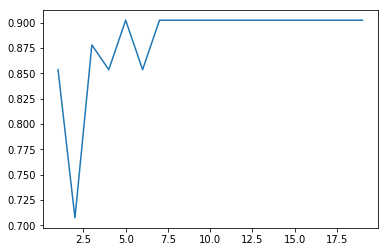

In [39]:
scores = []
n_neighb = [1, 2, 3, 4, 5, 6] + list(range(7, 20, 3))

for k in n_neighb:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_kp = knn.predict(X_test)
    scores.append(recall_score(y_test, y_kp))

plt.plot(n_neighb, scores, label='Izbor parametra k')

I da, vidimo da nismo baš dobro izabrali k, odnosno da bismo postigli veći recall ako nam je k=5 ili veće od 8. Kao što je pomenuto i ranije, kada postižemo istu tačnost sa više modela, uvek biramo prostiji model. Zato će nam k biti 5: 

In [40]:
knn_final = KNeighborsClassifier(n_neighbors=5, metric='euclidean') # metric='minkowski', p=2
knn_final.fit(X_train, y_train)
y_pred_final = knn_final.predict(X_test)
y_pred_final[:10]
recall_score(y_test, y_pred_final)

0.9024390243902439

# Literatura

> 1. [Machine Learning A-Z](https://www.udemy.com/machinelearning/), Kiril Eremenko, Superdatascience

> 2. [Open Machine Learning Course Medium](https://medium.com/open-machine-learning-course)

> 3. Materijali sa predmeta [Mašinsko učenje, FON](http://odlucivanje.fon.bg.ac.rs/predmeti/osnovne-studije/masinsko-ucenje/) - Prediktivni modeli, Miloš Jovanović

> 4. [sckikit-learn Tutorials](https://scikit-learn.org/stable/tutorial/index.html)

> 5. [Decision Trees Algorithms, Deep Math ML AI, Medium](https://medium.com/deep-math-machine-learning-ai/chapter-4-decision-trees-algorithms-b93975f7a1f1)

> 6. [ID3 algoritam](http://odlucivanje.fon.bg.ac.rs/wp-content/uploads/skripta-id3.pdf), [kNN Algoritam](http://odlucivanje.fon.bg.ac.rs/wp-content/uploads/kNN-v1.2.pdf), Teorija odlučivanja, FON

> 7. [Bias vs. Variance Trade-off Infographic](https://elitedatascience.com/bias-variance-tradeoff)
